In [ ]:
## PCA/TSNE analysis
## https://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/005_Chemical_space_analysis_and_visualization.ipynb

## 2024.01.05
## Peter M.U. Ung @ gRED
## Analysis the chemical diversity and overlaps of multiple libraries. Using the generic/hetero Murcko structures
## to group similar cpds together instead of using full-mol structure, which is sensitive to the decorations and
## affect the proper grouping of cpds with the same scaffold. PCA does an okay job in spreading out the chemical 
## space but still very packed. Use t-SNE to better spread out the chemical space for visualization.

## Python 3.9

In [48]:
import pandas as pd               # 1.4.3
from rdkit import Chem            # 2022.09
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Cluster import Butina
from rdkit.Chem import PandasTools as rdpd

In [49]:
import numpy as np          # 1.23.1
import seaborn as sns       # 0.11.2
import matplotlib.pyplot as plt  # 3.5.1
from sklearn.manifold import TSNE  # 1.1.1
from sklearn.decomposition import PCA

// pre-process raw data by getting the sdfTag of "GNumber", remove excess data in sdfTag
// Enamine data had a russian character that disrupts utf-8 reading, remove sdfTag "Mol Weight" to solve issue

In [3]:
## Defined SMARTS of CRBN binders (glutarimide, succinimide, hept-imide, pyrazole, glutarimide-tauto)
crbn_smarts = ['*~*~1~*~*~[#6](~[#8,#16;H0])~[#7;H0,H1]~*~1','*~*~1~*~[#6](~[#8,#16;H0])~[#7;H0,H1]~*~1',
               '*~*~1~*~*~*-[#6](~[#8,#16;H0])~[#7;H0,H1]~*~1','*~*~1~*~[#7;H1]~[#7;H0]~[*;H1]~1',
               '[#8;H1]~[#6;H0]~1~*~*~*~[#7;H0]~1']

## Defined reagent groups to be removed; remove VHL binder and likely E1 binder
reagent_str = ['*[Br,I]','[F,Cl,Br]-S(=O)=O','*C(=O)-C-[Cl,Br,I]','O-B(-O)-*', 'NC(=O)C1CC(O)CN1C(*)=O',
              'O=C1NC(=O)C(=*)C(=O)N1c1ccccc1']

In [5]:
## Enamine: remove reagents and select only known CRBN-binder motifs
## 'Mol Weight' contain non utf-8 code; -rename 'CatalogID=GNumber' -title GNumber -remove 'Mol Weight'
df_2 = rdpd.LoadSDF('../Enamine_Molecular_Glues_and_intermdiates_stock_12744cmpds_20230822.clean.sdf.gz', 
                    removeHs=False).reset_index(drop=True)
len(df_2)

[19:41:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[19:41:43] ERROR: Could not sanitize molecule ending on line 889053
[19:41:43] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted


12743

In [6]:
removal2 = [ df_2[df_2.ROMol >= Chem.MolFromSmarts(smarts)] for smarts in reagent_str ]
df_remove2 = pd.concat(removal2).drop_duplicates(subset=['GNumber'])
print(len(df_remove2))

df_x2 = df_2[~df_2.GNumber.isin(df_remove2.GNumber)].reset_index(drop=True)
sele2 = [ df_x2[df_x2.ROMol >= Chem.MolFromSmarts(smarts)] for smarts in crbn_smarts ]
df_y2 = pd.concat(sele2).reset_index(drop=True)
df_enm = df_y2.drop_duplicates(subset=['GNumber']).reset_index(drop=True)
df_enm['Data_source'] = 'Enamine'
print(len(df_enm))

622
11756


In [7]:
## Mcule: remove reagents and select only known CRBN-binder motifs
## -rename 'GNumber=TITLE'
df_3 = rdpd.LoadSDF('../mcule.molecular_glue_library_20230919.clean.sdf.gz', removeHs=False).reset_index(drop=True)
print(len(df_3))

10959


In [8]:
removal3 = [ df_3[df_3.ROMol >= Chem.MolFromSmarts(smarts)] for smarts in reagent_str ]
df_remove3 = pd.concat(removal3).drop_duplicates(subset=['GNumber'])
print(len(df_remove3))

df_x3 = df_3[~df_3.GNumber.isin(df_remove3.GNumber)].reset_index(drop=True)
sele3 = [ df_x3[df_x3.ROMol >= Chem.MolFromSmarts(smarts)] for smarts in crbn_smarts ]
df_y3 = pd.concat(sele3).reset_index(drop=True)
df_mcule = df_y3.drop_duplicates(subset=['GNumber']).reset_index(drop=True)
df_mcule['Data_source'] = 'Mcule'
print(len(df_mcule))

7107
3834


In [9]:
## Asinex: remove reagents and select only known CRBN-binder motifs
## -rename 'IDNUMBER=GNumber' -title GNumber
df_4 = rdpd.LoadSDF('../asinex.2023_all_glue.clean.sdf.gz', removeHs=False).reset_index(drop=True)
print(len(df_4))

1440


In [10]:
removal4 = [ df_4[df_4.ROMol >= Chem.MolFromSmarts(smarts)] for smarts in reagent_str ]
df_remove4 = pd.concat(removal4).drop_duplicates(subset=['GNumber'])
print(len(df_remove4))

df_x4 = df_4[~df_4.GNumber.isin(df_remove4.GNumber)].reset_index(drop=True)
sele4 = [ df_x4[df_x4.ROMol >= Chem.MolFromSmarts(smarts)] for smarts in crbn_smarts ]
df_y4 = pd.concat(sele4).reset_index(drop=True)
df_asi = df_y4.drop_duplicates(subset=['GNumber']).reset_index(drop=True)
df_asi['Data_source'] = 'Asinex'
print(len(df_asi))

23
332


In [11]:
## Concatenate all datasets, add Murcko data
df_all = pd.concat([df_enm, df_mcule, df_asi]).reset_index(drop=True).fillna('')
len(df_all)
rdpd.RemoveSaltsFromFrame(df_all, molCol='ROMol')
rdpd.AddMurckoToFrame(df_all, MurckoCol='Murcko_smiles', Generic=True)
rdpd.AddMurckoToFrame(df_all, MurckoCol='hetero_Murcko_smiles', Generic=False)
df_all['Mol_murcko'] = df_all['Murcko_smiles'].map(Chem.MolFromSmiles)
df_all['Mol_hetero_murcko'] = df_all['hetero_Murcko_smiles'].map(Chem.MolFromSmiles)

## Add simple molecular descriptors
df_all['MW'] = df_all.ROMol.map(Descriptors.MolWt)
df_all['HA'] = df_all.ROMol.map(Descriptors.HeavyAtomCount)

In [12]:
## Mark duplicates, use GNE as primary unique
df_all['full_smiles'] = df_all.ROMol.map(Chem.MolToSmiles)
duplicates = df_all.duplicated(subset=['full_smiles'], keep='first')
df_all['Duplicates'] = duplicates.astype('uint8')
sum(duplicates.astype('uint8'))

103

In [13]:
## generic Murcko identity grouping
group = df_all[['Murcko_smiles']].groupby(['Murcko_smiles']).sum()
group['murcko_num'] = df_all[['Murcko_smiles']].groupby(['Murcko_smiles']).size()
group.sort_values(by=['murcko_num','Murcko_smiles'], ascending=[False,False], inplace=True)
group.reset_index(inplace=True)
group

,Murcko_smiles,murcko_num
0,CC1CCC(C2C(C)C3CCCCC3C2C)C(C)C1,641
1,CC1CCC(C2CC3CCCCC3C2C)C(C)C1,372
2,CC1CCC(C2CC3C(CC(C)C4CCCCC4)CCCC3C2C)C(C)C1,233
3,CC(CCC1CCCC2C(C)C(C3CCC(C)CC3C)C(C)C12)CC1CCCCC1,219
4,CC1CCC2CCCCC12,150
...,...,...
4821,CC(CC(C(C)CC1CC1)C1CCCCC1)C1CCC2C(C)CC(C)C2C1,1
4822,CC(C1CCC(C2CCCC3CCCC32)CC1)C1CCC(C(C)(C)CC2CCC...,1
4823,CC(C)(CC1CCCCC1)C1CCCCC1,1
4824,CC(C)(CC1CCCC2CCCC21)C1CCCCC1,1


In [14]:
clusters = []
for clust_id, item in group.iterrows():
    tmp = df_all[df_all['Murcko_smiles'].isin([item['Murcko_smiles']])].index
    clusters.append([ [row, clust_id, item['murcko_num'], i] for i, row in enumerate(tmp) ])

## Reorder the flattened list of lists, so that 1st element corresponds to df_all index number
## *_identical_id: the Murcko group/cluster ID
## *_num: number of members within this Murcko group/cluster
## *_group_num: within this Murcko group/cluster, the rank number id (rank has no meaning)
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_all['murcko_identical_id'] = list(zip(*clust_combine))[1]
df_all['murcko_num'] = list(zip(*clust_combine))[2]
df_all['murcko_group_num'] = list(zip(*clust_combine))[3]

In [15]:
## hetero Murcko identity grouping
h_group = df_all[['hetero_Murcko_smiles']].groupby(['hetero_Murcko_smiles']).sum()
h_group['hetero_murcko_num'] = df_all[['hetero_Murcko_smiles']].groupby(['hetero_Murcko_smiles']).size()
h_group.sort_values(by=['hetero_murcko_num','hetero_Murcko_smiles'], ascending=[False,False], inplace=True)
h_group.reset_index(inplace=True)
h_group

,hetero_Murcko_smiles,hetero_murcko_num
0,O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1,620
1,O=C1CCC(N2Cc3ccccc3C2=O)C(=O)N1,370
2,O=C1CCC(N2Cc3c(NC(=O)c4ccccc4)cccc3C2=O)C(=O)N1,185
3,O=C1CCC(N2C(=O)c3cccc(OCC(=O)Nc4ccccc4)c3C2=O)...,181
4,O=C1NCc2ccccc21,122
...,...,...
8214,C=C1CCN(c2cccc3c2C(=O)N(C2CC(=O)NC2=O)C3=O)CC1,1
8215,C=C1CCN(C(=O)c2cn(-c3ccc4c(c3)CN(C3CCC(=O)NC3=...,1
8216,C=C1CCN(C(=O)c2cn(-c3ccc4c(c3)C(=O)N(C3CCC(=O)...,1
8217,C=C1CC(NC(=O)CCCCCCCNc2cccc3c2C(=O)N(C2CCC(=O)...,1


In [16]:
clusters = []
for clust_id, item in h_group.iterrows():
    tmp = df_all[df_all['hetero_Murcko_smiles'].isin([item['hetero_Murcko_smiles']])].index
    clusters.append([ [row, clust_id, item['hetero_murcko_num'], i] for i, row in enumerate(tmp) ])
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_all['hetero_identical_id'] = list(zip(*clust_combine))[1]
df_all['hetero_murcko_num'] = list(zip(*clust_combine))[2]
df_all['hetero_murcko_group_num'] = list(zip(*clust_combine))[3]

In [17]:
class FP:
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return '{0} bit FP'.format(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, radius=2, nBits=2048, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circular (Morgan) fingerprint.  
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints  
    mol : rdkit.Chem.rdchem.Mol
    radius : float      Fingerprint radius, default 2
    nBits : int         Length of hashed fingerprint (without descriptors), default 2048
    useFeatures : bool  To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool       If True, returns for each bit number of appearances of each substructure (counts). Default False (fingerprint is binary)
    dtype : np.dtype    Numpy data type. Defaults to np.float32 for scikit-learn
    Returns
    ML.FP               Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)
    if counts is True:
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures)
    DataStructs.ConvertToNumpyArray(fp, arr)    
    return FP(arr, range(nBits))

In [18]:
def CalcFPTanimoto( Fp, cutoff=0.4 ):
    ## Generate the FP distance matrix:
    ## This scheme is more efficient as only half of the matrix is calculated
    ## as it is symmetric, O(0.5*N^2-N). Another version of math that uses
    ## Pandas mapping has no shortcut, O(N^2), much slower even as serialized
    dists = []
    for i in list(range(1, len(Fp))):  # starting @ 1 to avoid self-calculation
        sims = DataStructs.BulkTanimotoSimilarity(Fp[i], Fp[:i])
        dists.extend([1-x for x in sims])

    ## Cluster the data into list of lists of positional index (df or array), 
    ## each list with members within the cutoff:
    FP_clusters = Butina.ClusterData(dists, len(Fp), float(cutoff), isDistData=True)
    return FP_clusters

In [19]:
## Whole-molecule clustering by Tanimoto cutoff with ECFP4_2048
df_all['ecfp4'] = df_all['ROMol'].map(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048))
FP_clusters = CalcFPTanimoto(df_all['ecfp4'], cutoff=0.4)

clusters = []
for clust_id, clust_members in enumerate(FP_clusters):
    indexes = df_all[df_all.index.isin(clust_members)].index.tolist()
    clusters.append( [[row, clust_id, len(clust_members), i] for i, row in enumerate(indexes)] )

## combine the list of indexes and sort it to match df_all index, remerge cluster info into df
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_all['whole_cluster_id'] = list(zip(*clust_combine))[1]
df_all['whole_cluster_num'] = list(zip(*clust_combine))[2]
df_all['whole_cluster_group_num'] = list(zip(*clust_combine))[3]

print("## No. of cluster: "+str(len(clusters))+" for Tc = "+str(0.4)+" ##\n")

## No. of cluster: 3471 for Tc = 0.4 ##



In [20]:
df_all['FP_full']   = df_all['ROMol'].map(get_cfps)
df_all['FP_murcko'] = df_all['Mol_murcko'].map(get_cfps)
df_all['FP_hetero'] = df_all['Mol_hetero_murcko'].map(get_cfps)

In [21]:
## PCA analysis: generic Murcko
murcko_FP_data = df_all['FP_murcko'].map(lambda m: m.fp).tolist()  # extract FP as np.array
pca = PCA(n_components=3, random_state=0)
pca_full = pca.fit_transform(murcko_FP_data)
df_all['PCA_murcko_1'] = pca_full.T[0]
df_all['PCA_murcko_2'] = pca_full.T[1]
df_all['PCA_murcko_3'] = pca_full.T[2]

In [22]:
## since many generic Murcko groups have many members, could be too much data to display, reduce by not looking at small groups
## and only showing the first member of the group
data = df_all[df_all['murcko_num'] > 3].groupby('murcko_identical_id').nth(0).reset_index()
len(data)

666

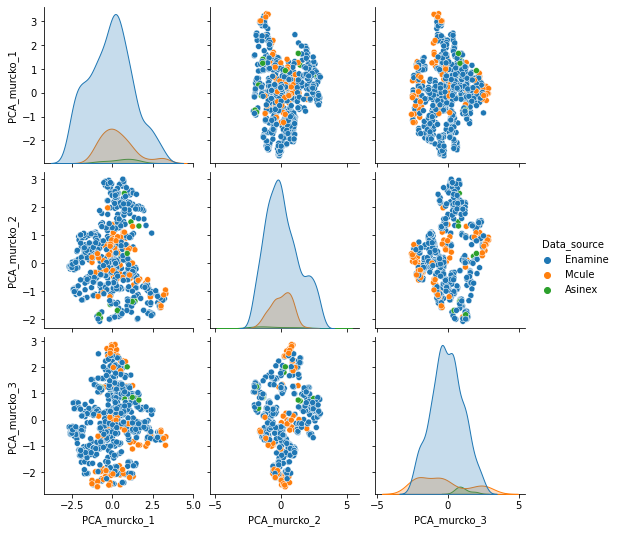

In [26]:
sns.pairplot(data, hue='Data_source', vars=['PCA_murcko_1','PCA_murcko_2','PCA_murcko_3'] )

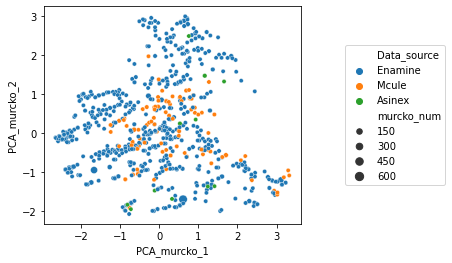

In [27]:
sns_pca_murcko = sns.scatterplot(data=data, x='PCA_murcko_1', y='PCA_murcko_2', size='murcko_num', hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_pca_murcko.legend(loc='center right', bbox_to_anchor=(1.58,.5))

In [26]:
sns_pca_murcko.figure.savefig('Degrader_CRBN.all_lib.murcko_PCA.png', dpi=300)

In [28]:
## PCA Analysis: hetero Murcko
hetero_FP_data = df_all['FP_hetero'].map(lambda m: m.fp).tolist()  # extract FP as np.array
pca = PCA(n_components=3, random_state=0)
pca_hetero = pca.fit_transform(hetero_FP_data)
df_all['PCA_hetero_1'] = pca_hetero.T[0]
df_all['PCA_hetero_2'] = pca_hetero.T[1]
df_all['PCA_hetero_3'] = pca_hetero.T[2]

In [29]:
data2 = df_all[df_all['hetero_murcko_num'] > 3].groupby('hetero_identical_id').nth(0).reset_index()
len(data2)

498

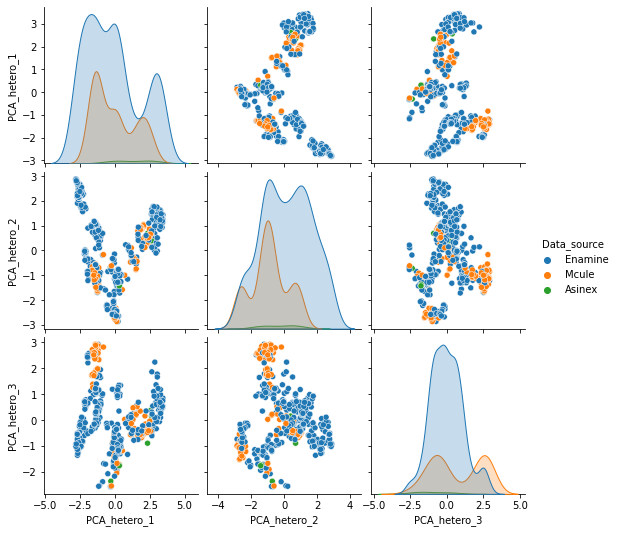

In [30]:
sns.pairplot(data2, hue='Data_source', vars=['PCA_hetero_1','PCA_hetero_2','PCA_hetero_3'])

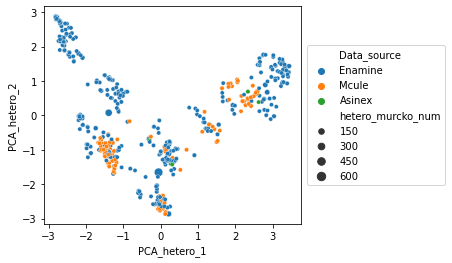

In [31]:
sns_pca_hetero = sns.scatterplot(data=data2, x='PCA_hetero_1', y='PCA_hetero_2', size='hetero_murcko_num', hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_pca_hetero.legend(loc='center right', bbox_to_anchor=(1.58,.5))

In [31]:
sns_pca_hetero.figure.savefig('Degrader_CRBN.all_lib.hetero_murcko_PCA.png', dpi=300)

In [32]:
## PCA Analysis: whole molecule
whole_FP_data = df_all['FP_full'].map(lambda m: m.fp).tolist()  # extract FP as np.array
pca = PCA(n_components=3, random_state=0)
pca_whole = pca.fit_transform(whole_FP_data)
df_all['PCA_whole_1'] = pca_whole.T[0]
df_all['PCA_whole_2'] = pca_whole.T[1]
df_all['PCA_whole_3'] = pca_whole.T[2]

In [33]:
datax = df_all[df_all['whole_cluster_num'] > 3].groupby('whole_cluster_id').nth(0).reset_index()
len(datax)

469

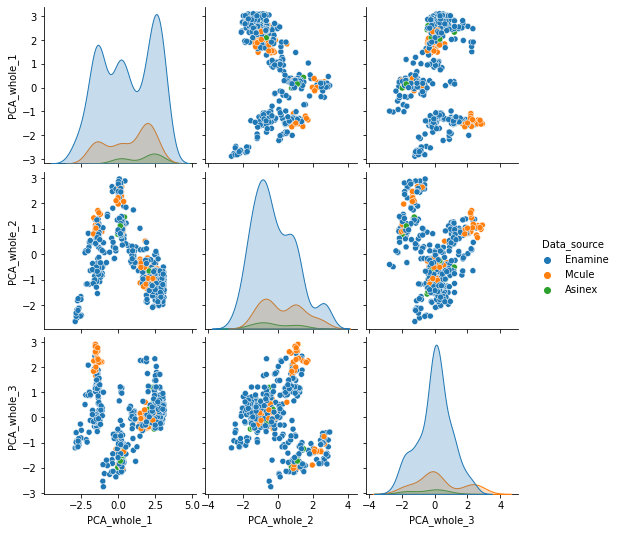

In [34]:
sns.pairplot(datax, hue='Data_source', vars=['PCA_whole_1','PCA_whole_2','PCA_whole_3'])

In [35]:
## TSNE with PCA preprocessing: Settings
pca_model  = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000, n_jobs=-1,
                  learning_rate='auto', init='pca')

In [36]:
## TSNE with PCA preprocessing: generic Murcko 
tsne_pca_murcko = tsne_model.fit_transform(pca_model.fit_transform(murcko_FP_data))
df_all['TSNE_murcko_1'] = tsne_pca_murcko.T[0]
df_all['TSNE_murcko_2'] = tsne_pca_murcko.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [37]:
## Only showing the 1st appearing mol in the 'murcko_identical_id' group/cluster with more than X members
data3 = df_all[df_all['murcko_num'] > 3].groupby('murcko_identical_id').nth(0).reset_index()
len(data3)

666

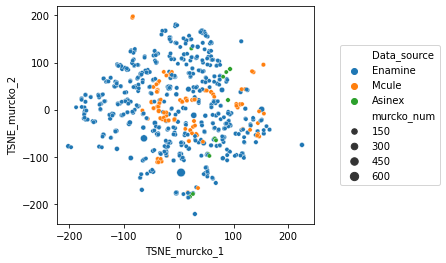

In [38]:
sns_tsne_murcko = sns.scatterplot(data=data3, x='TSNE_murcko_1', y='TSNE_murcko_2', size='murcko_num', hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_tsne_murcko.legend(loc='center right', bbox_to_anchor=(1.51,.5))

In [196]:
sns_tsne_murcko.figure.savefig('Degrader_CRBN.all_lib.murcko_tSNE.png', dpi=300)

In [39]:
## TSNE with PCA preprocessing: hetero Murcko 
tsne_pca_hetero = tsne_model.fit_transform(pca_model.fit_transform(hetero_FP_data))
df_all['TSNE_hetero_1'] = tsne_pca_hetero.T[0]
df_all['TSNE_hetero_2'] = tsne_pca_hetero.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [40]:
data4 = df_all[df_all['hetero_murcko_num'] > 2].groupby('hetero_identical_id').nth(0).reset_index()

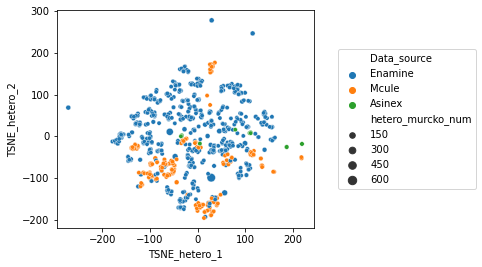

In [41]:
sns_tsne_hetero = sns.scatterplot(data=data4, x='TSNE_hetero_1', y='TSNE_hetero_2', size='hetero_murcko_num', hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_tsne_hetero.legend(loc='center right', bbox_to_anchor=(1.65,.5))

In [42]:
sns_tsne_hetero.figure.savefig('Degrader_CRBN.all_lib.hetero_murcko_tSNE.png', dpi=300)

In [43]:
## TSNE with PCA preprocessing: whole molecule
tsne_pca_whole = tsne_model.fit_transform(pca_model.fit_transform(whole_FP_data))
df_all['TSNE_whole_1'] = tsne_pca_whole.T[0]
df_all['TSNE_whole_2'] = tsne_pca_whole.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [44]:
data5 = df_all[df_all['whole_cluster_num'] > 2].groupby('whole_cluster_id').nth(0).reset_index()

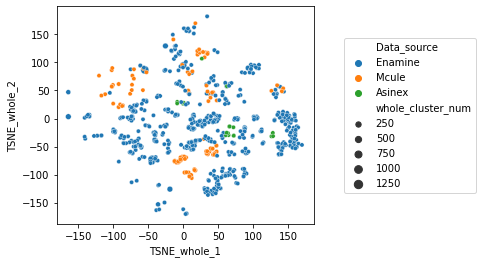

In [47]:
sns_tsne_hetero = sns.scatterplot(data=data5, x='TSNE_whole_1', y='TSNE_whole_2', size='whole_cluster_num', hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_tsne_hetero.legend(loc='center right', bbox_to_anchor=(1.65,.5))

In [50]:
df_all = rdpd.LoadSDF('Degrader_CRBN.all_lib.murcko_clust.tsne.sdf.gz', removeHs=False)

In [51]:
df_out = df_all.fillna('').drop(columns=['Mol_murcko','Mol_hetero_murcko','FP_full','FP_murcko','FP_hetero','ecfp4'])
len(df_all.columns) - len(df_out.columns)

10

In [52]:
## Result can be analyze by other specialized visualization tools
rdpd.WriteSDF(df_out, 'CRBN_lib_example.Murcko_clust.tsne.sdf.gz', properties=list(df_out.columns))